### Convolve Function

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

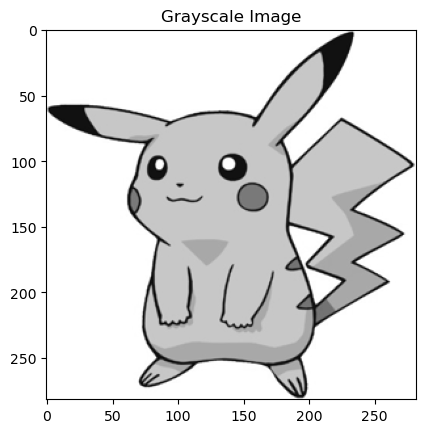

In [25]:
img = Image.open("img.jpg").convert("L")
img = img.resize((282, 282))
img = np.array(img)

plt.imshow(img, cmap='gray')
plt.title("Grayscale Image")
plt.show()

In [4]:
def conv(img, kernel, padding=True):
    n = img.shape[0]
    k = kernel.shape[0]

    if padding:
        p = (k - 1) // 2
        padded_img = np.pad(img, pad_width=p, mode='constant', constant_values=0)
    else:
        padded_img = img

    output_size = n if padding else (n - k + 1)
    output = np.zeros((output_size, output_size))

    # Perform convolution
    for i in range(output_size):
        for j in range(output_size):
            region = padded_img[i:i+k, j:j+k]
            output[i, j] = np.sum(region * kernel)

    return output

### 1. Sobel Kernel

In [40]:
sobel_kx = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

sobel_ky = np.array([[-1, -2, -1],
                     [0, 0, 0],
                     [1, 2, 1]])

conv_x = conv(img, sobel_kx)
conv_y = conv(img, sobel_ky)

grad_mag = np.sqrt(np.square(conv_x) + np.square(conv_y))
threshold = 0.1
grad_mag = ((grad_mag/grad_mag.max())>threshold).astype(np.uint8)

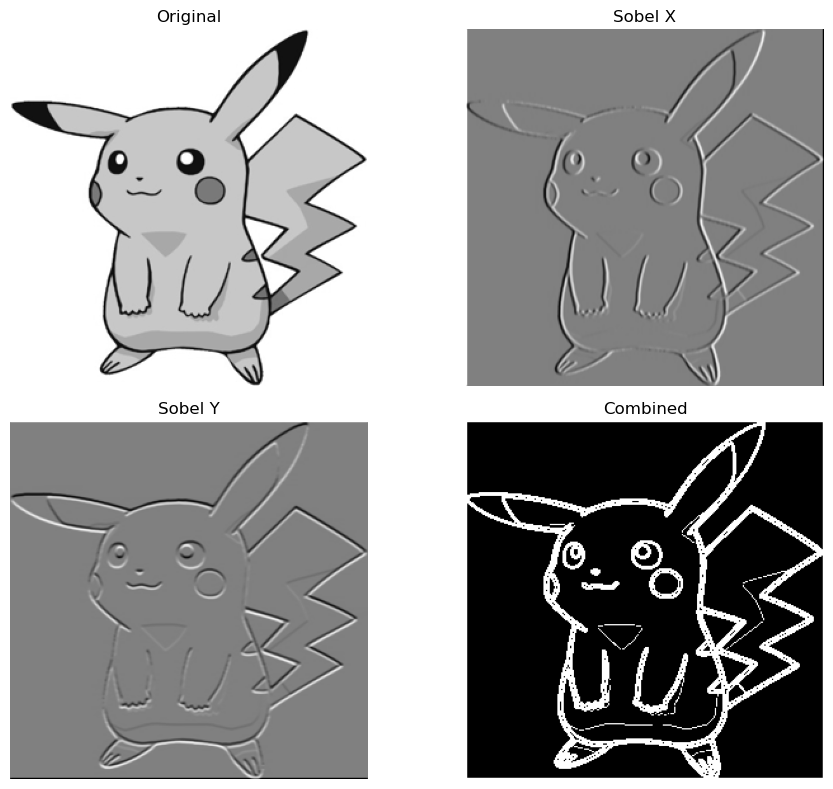

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Original')

axs[0, 1].imshow(conv_x, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Sobel X')

axs[1, 0].imshow(conv_y, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Sobel Y')

axs[1, 1].imshow(grad_mag, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Combined')

plt.tight_layout()
plt.show()

### 2. Scharr

In [38]:
scharr_y = np.array([[3, 10, 3],
                     [0, 0, 0],
                     [-3, -10, -3]])

scharr_x = np.array([[3, 0, -3],
                     [10, 0, -10],
                     [3, 0, -3]])

gx = conv(img, scharr_x)
gy = conv(img, scharr_y)
grad_mag = np.sqrt(gx**2 + gy**2)

# with thresholdng
threshold = 0.1
grad_mag = ((grad_mag/grad_mag.max())>threshold).astype(np.uint8)

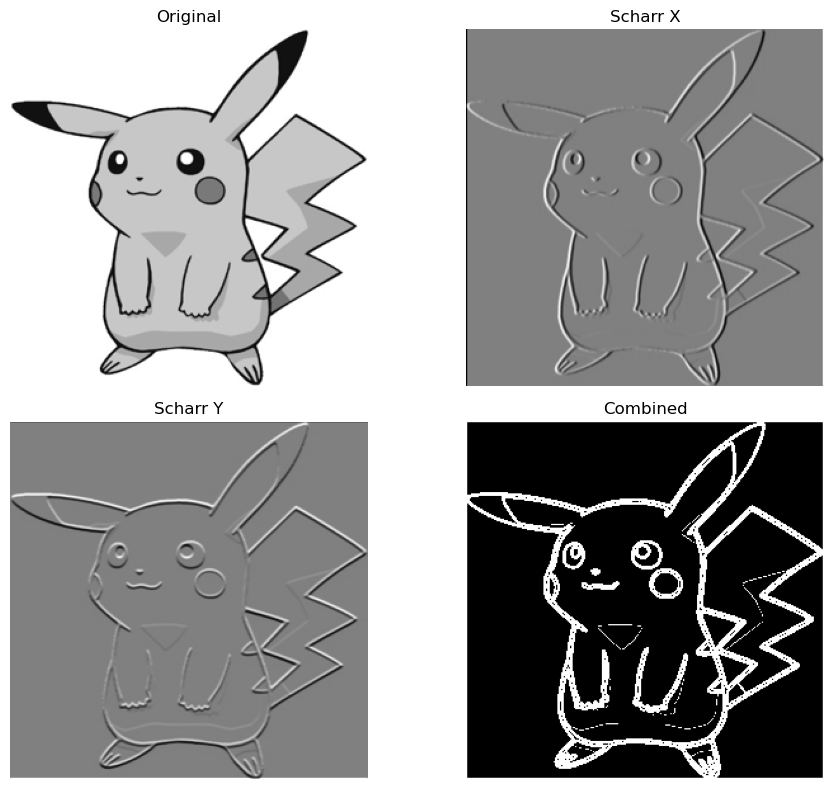

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Original')

axs[0, 1].imshow(gx, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Scharr X')

axs[1, 0].imshow(gy, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Scharr Y')

axs[1, 1].imshow(grad_mag, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Combined')

plt.tight_layout()
plt.show()

### 3. Feldman/Prewitt

In [42]:
feldman_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]])

feldman_y = np.array([[1, 1, 1],
                      [0, 0, 0],
                      [-1, -1, -1]])

gx = conv(img, feldman_x)
gy = conv(img, feldman_y)
grad_mag = np.sqrt(gx**2 + gy**2)

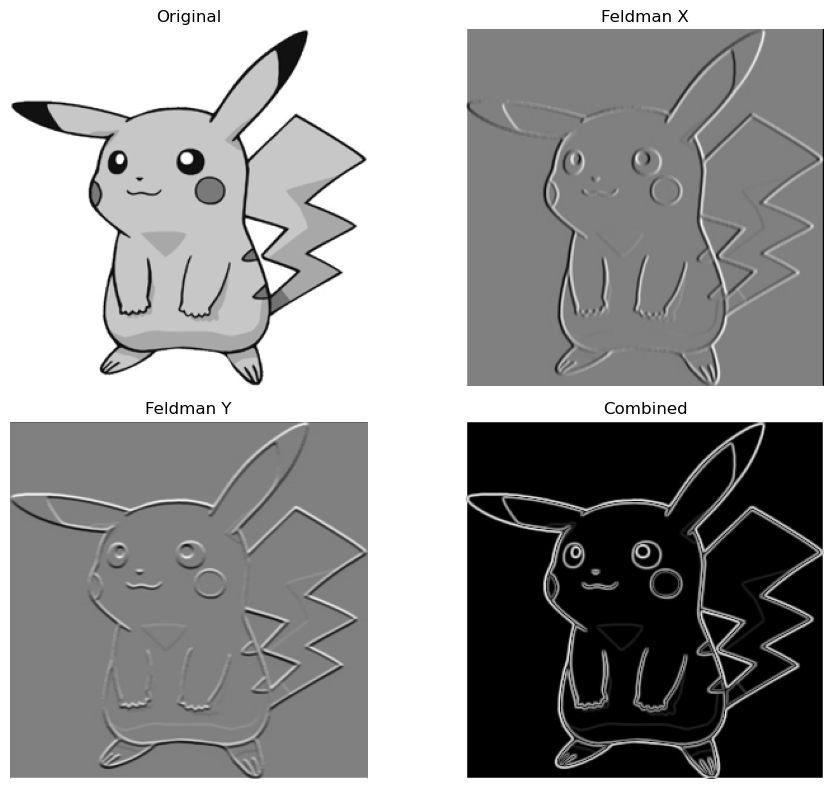

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Original')

axs[0, 1].imshow(gx, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Feldman X')

axs[1, 0].imshow(gy, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Feldman Y')

axs[1, 1].imshow(grad_mag, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Combined')

plt.tight_layout()
plt.show()

### 4. Canny Edge

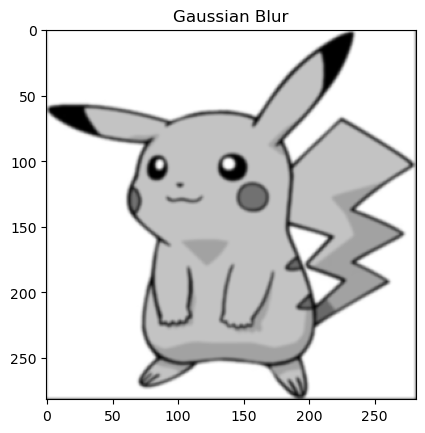

In [45]:
# Step 1: GAUSsian blur
gaussian_kernel = (1/273) * np.array([
    [1,  4,  7,  4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1,  4,  7,  4, 1]
])

blurred = conv(img, gaussian_kernel)

plt.imshow(blurred, cmap='gray')
plt.title("Gaussian Blur")
plt.show()

In [46]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

grad_x = conv(blurred, sobel_x)
grad_y = conv(blurred, sobel_y)

magnitude = np.sqrt(np.square(conv_x) + np.square(conv_y))
direction = np.arctan2(grad_y, grad_x) * (180.0 / np.pi)
direction[direction < 0] += 180


In [47]:
def non_max_suppression(mag, dir):
    nms = np.zeros_like(mag)
    dir = ((dir + 22.5) // 45) * 45

    for i in range(1, mag.shape[0] - 1):
        for j in range(1, mag.shape[1] - 1):
            q = 255
            r = 255
            angle = dir[i, j]
            if angle == 0:
                q = mag[i, j + 1]
                r = mag[i, j - 1]
            elif angle == 45:
                q = mag[i + 1, j - 1]
                r = mag[i - 1, j + 1]
            elif angle == 90:
                q = mag[i + 1, j]
                r = mag[i - 1, j]
            elif angle == 135:
                q = mag[i - 1, j - 1]
                r = mag[i + 1, j + 1]

            if mag[i, j] >= q and mag[i, j] >= r:
                nms[i, j] = mag[i, j]
    return nms

nms = non_max_suppression(magnitude, direction)

In [73]:
def double_threshold(img, low_ratio=0.1, high_ratio=0.15):
    high = img.max() * high_ratio
    low = high * low_ratio

    strong = 250
    weak = 150

    output = np.zeros_like(img)
    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    output[strong_i, strong_j] = strong
    output[weak_i, weak_j] = weak
    return output, weak, strong

thresholded, weak, strong = double_threshold(nms)

In [74]:
def hysteresis(img, weak, strong=255):
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            if img[i, j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

edges = hysteresis(thresholded, weak, strong)

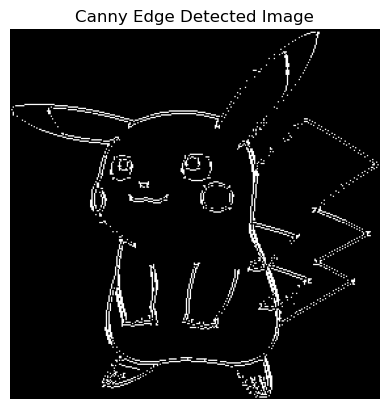

In [75]:
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detected Image")
plt.axis('off')
plt.show()